# Chemprop run basic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint

from chemprop import data, featurizers, models, nn

In [3]:
chemprop_dir = Path.cwd()
input_path = chemprop_dir / 'pulmonary' / 'data' / 'all_data.csv'
num_workers = 0
smiles_col = 'smiles'
target_cols = ['quantified_delivery']

In [4]:
df_input = pd.read_csv(input_path)
df_input = df_input.loc[df_input.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df_input.loc[:,smiles_col].values
ys = df_input.loc[:, target_cols].values

/tmp/ipykernel_118300/4188673135.py:1: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_input = pd.read_csv(input_path)


In [5]:
ws = ys.copy()
ws[ws >= 2] = 3
ws[(ws < 2)] = 1
#ws[ws <= 1] = 0.1

(array([8922.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         455.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

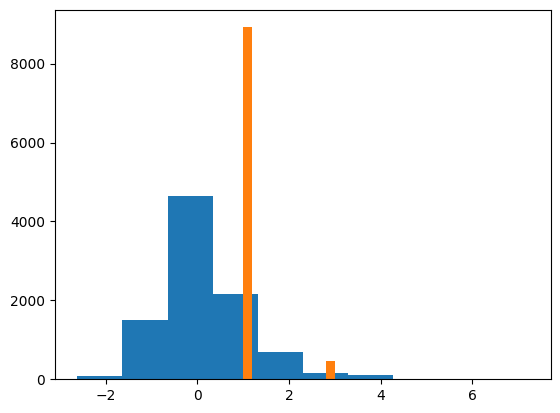

In [6]:
plt.hist(ys)
plt.hist(ws)

In [7]:
all_data = [data.MoleculeDatapoint.from_smi(smi,y,weight=w) for smi,y,w in zip(smis,ys, ws)]  

mols = [d.mol for d in all_data]

train_indices, val_indices, test_indices = data.make_split_indices(mols,"random",(0.8,0.1,0.1))
train_data, val_data, test_data = data.split_data_by_indices(all_data, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()
val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, num_workers=num_workers,batch_size=512)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers,shuffle=False, batch_size=512)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers,shuffle=False,batch_size=512)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [8]:
mp = nn.BondMessagePassing()
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [9]:
agg = nn.MeanAggregation()
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [10]:

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
ffn = nn.RegressionFFN(output_transform=output_transform)
batch_norm = True
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


In [ ]:
metric_list = [nn.metrics.MSE(), nn.metrics.RMSE(), nn.metrics.MAE(), nn.metrics.R2Score()]

In [12]:
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weigh

In [13]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

In [14]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=500,
    callbacks=[checkpointing]
)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(mpnn, train_loader, val_loader)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/LNP/ml/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve pe

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/chemprop/data/collate.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(weights, dtype=torch.float).unsqueeze(1),


Epoch 499: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s, train_loss_step=0.234, val_loss=1.130, train_loss_epoch=0.207]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, train_loss_step=0.234, val_loss=1.130, train_loss_epoch=0.207]


In [16]:
results = trainer.test(dataloaders=test_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=143-val_loss=1.06.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=143-val_loss=1.06.ckpt
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` t

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6222567558288574     │
│          test/r2          │    0.2537820339202881     │
│         test/rmse         │    0.8460294008255005     │
└───────────────────────────┴───────────────────────────┘

In [17]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Text(0, 0.5, 'Predictions')

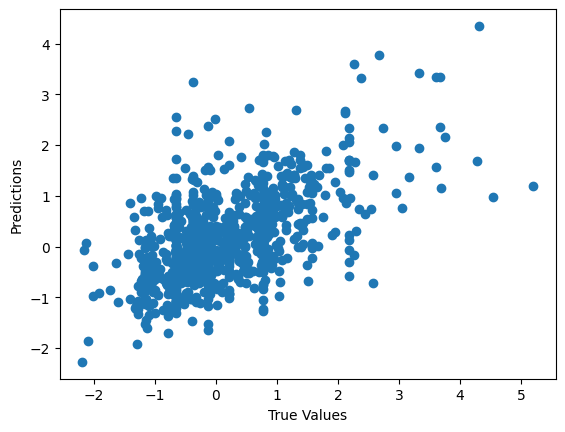

In [18]:
plt.scatter(test_vals, test_preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [19]:
from torchmetrics.regression import R2Score
import torch

In [20]:
r2score = R2Score()
r2score(torch.tensor(test_preds), torch.tensor(test_vals))

tensor(0.2538, dtype=torch.float64)

In [21]:
train_preds = np.concatenate(trainer.predict(mpnn,train_loader),axis=0).flatten()
train_vals = np.concatenate(train_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Predicting DataLoader 0: 100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


Text(0, 0.5, 'Predictions')

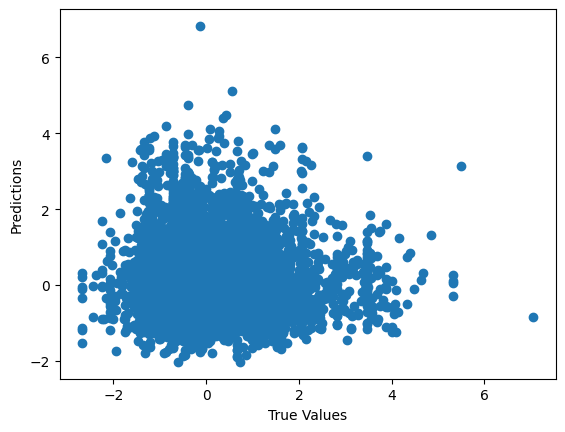

In [22]:
plt.scatter(train_vals, train_preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [23]:
r2score(torch.tensor(train_preds), torch.tensor(train_vals))

tensor(-0.8299, dtype=torch.float64)

# Chemprop run regression 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

/tmp/ipykernel_316017/288394649.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


In [3]:
'''
Ws = Ys.copy()
Ws[Ys > 3] = 4
Ws[Ws < 3] = 0.2
#Ws[(Ys <=2) & (Ys >=1)] = 1
#Ws[Ys < 1] = 0.3

plt.hist(Ys)
plt.hist(Ws)
'''

'\nWs = Ys.copy()\nWs[Ys > 3] = 4\nWs[Ws < 3] = 0.2\n#Ws[(Ys <=2) & (Ys >=1)] = 1\n#Ws[Ys < 1] = 0.3\n\nplt.hist(Ys)\nplt.hist(Ws)\n'

In [4]:
#datapoints = [data.MoleculeDatapoint.from_smi(smi,y,w) for smi,y,w in zip(smis, Ys, Ws)]
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [20]:
#mp = nn.message_passing.MessagePassing()
mp = nn.BondMessagePassing(depth=6, activation=nn.utils.Activation.RELU)
agg = nn.agg.SumAggregation()
#agg = nn.agg.NormAggregation()
#agg = nn.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.RegressionFFN(hidden_dim=1500, n_layers=3, dropout=0, activation='relu',output_transform=output_transform)
#predictor = nn.predictors.EvidentialFFN(hidden_dim=300, n_layers=1, dropout=0, activation='relu', output_transform=output_transform)

batch_norm = True
metrics = [nn.MSE(), nn.MAE(), nn.RMSE(), nn.R2Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metrics)

In [21]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/LNP/ml/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading `train_dataloader` to estimate number of stepping batches.
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | SumAggregation     | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 5.0 M  | train
4 | X_d_transform   | Identity           | 0      | train
5 | metrics         | ModuleList         | 0      | train
---------------------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s, train_loss_step=0.453, val_loss=0.646, train_loss_epoch=0.507]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s, train_loss_step=0.453, val_loss=0.646, train_loss_epoch=0.507]


In [22]:
results = trainer.test(dataloaders=test_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=17-val_loss=0.62.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=17-val_loss=0.62.ckpt
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to 

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6111679673194885     │
│         test/mse          │    0.6820507049560547     │
│          test/r2          │    0.2889314293861389     │
│         test/rmse         │    0.8258635997772217     │
└───────────────────────────┴───────────────────────────┘

In [23]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

train_preds = np.concatenate(trainer.predict(mpnn,train_loader),axis=0).flatten()
train_vals = np.concatenate(train_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



Predicting DataLoader 0: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


Text(0, 0.5, 'Test -- Predictions')

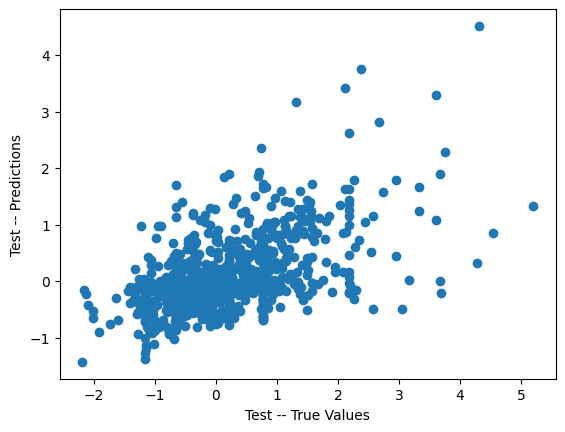

In [24]:
plt.scatter(test_vals, test_preds)
plt.xlabel('Test -- True Values')
plt.ylabel('Test -- Predictions')

'\nfrom torchmetrics.regression import R2Score\nimport torch\nr2score = R2Score()\nprint("Test R2 Score:")\nprint(r2score(torch.tensor(test_preds), torch.tensor(test_vals)))\nprint("Train R2 Score:")\nprint(r2score(torch.tensor(train_preds), torch.tensor(train_vals)))\n'

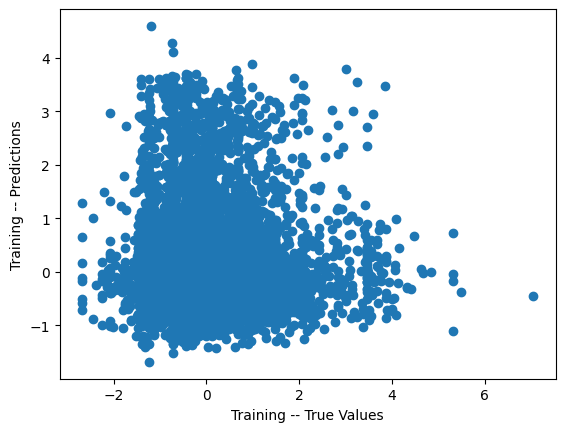

In [ ]:
plt.scatter(train_vals, train_preds)
plt.xlabel('Training -- True Values')
plt.ylabel('Training -- Predictions')

In [ ]:
from torchmetrics.regression import R2Score
import torch
r2score = R2Score()
print("Test R2 Score:")
print(r2score(torch.tensor(test_preds), torch.tensor(test_vals)))
print("Train R2 Score:")
print(r2score(torch.tensor(train_preds), torch.tensor(train_vals)))

# Chemprop run evidential 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

/tmp/ipykernel_286349/288394649.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


(array([8.100e+01, 1.507e+03, 4.639e+03, 2.165e+03, 6.970e+02, 1.480e+02,
        1.190e+02, 1.300e+01, 7.000e+00, 1.000e+00]),
 array([-2.62169095, -1.63712801, -0.65256508,  0.33199786,  1.3165608 ,
         2.30112374,  3.28568667,  4.27024961,  5.25481255,  6.23937549,
         7.22393842]),
 <BarContainer object of 10 artists>)

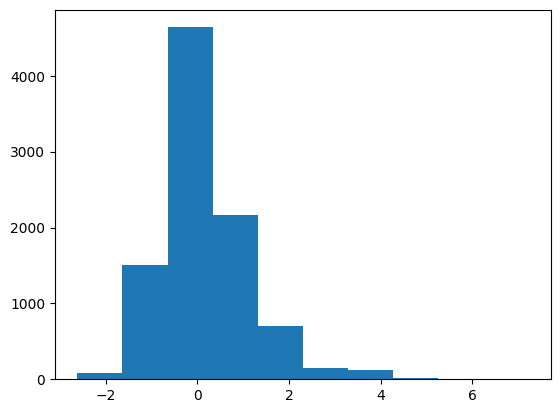

In [3]:
#Ws = Ys.copy()
#Ws[Ys > 3] = 4
#Ws[Ws < 3] = 0.2
#Ws[(Ys <=2) & (Ys >=1)] = 1
#Ws[Ys < 1] = 0.3

plt.hist(Ys)
#plt.hist(Ws)

In [4]:
#datapoints = [data.MoleculeDatapoint.from_smi(smi,y,w) for smi,y,w in zip(smis, Ys, Ws)]
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [ ]:
#mp = nn.message_passing.MessagePassing()
mp = nn.BondMessagePassing(depth=3, activation=nn.utils.Activation.RELU)
#agg = nn.agg.NormAggregation()
agg = nn.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
#predictor = nn.predictors.RegressionFFN(hidden_dim=300, n_layers=1, dropout=0, activation='relu',output_transform=output_transform)
predictor = nn.predictors.EvidentialFFN(hidden_dim=300, n_layers=1, dropout=0, activation='relu', output_transform=output_transform)

batch_norm = True
metrics = [nn.MSE(), nn.MAE(), nn.RMSE(), nn.R2Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metrics)

In [6]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s, train_loss_step=0.875, val_loss=1.070, train_loss_epoch=0.912]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s, train_loss_step=0.875, val_loss=1.070, train_loss_epoch=0.912]


In [7]:
test_preds = np.concatenate(np.concatenate(trainer.predict(mpnn,test_loader),axis=0),axis=0)
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

train_preds = np.concatenate(np.concatenate(trainer.predict(mpnn,train_loader),axis=0),axis=0)
train_vals = np.concatenate(train_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



Predicting DataLoader 0: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


Text(0, 0.5, 'Test -- Predictions')

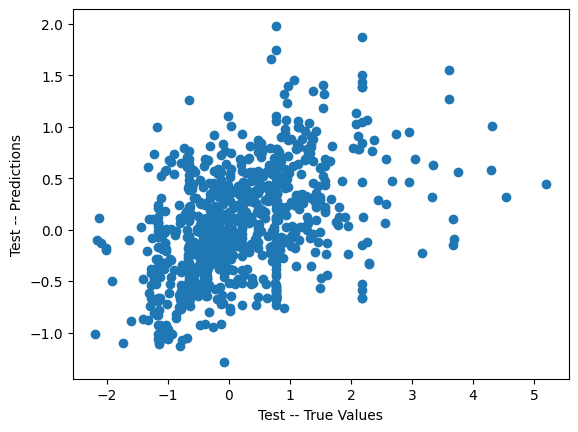

In [8]:
plt.scatter(test_vals, test_preds[:,0])
plt.xlabel('Test -- True Values')
plt.ylabel('Test -- Predictions')

Text(0, 0.5, 'Training -- Predictions')

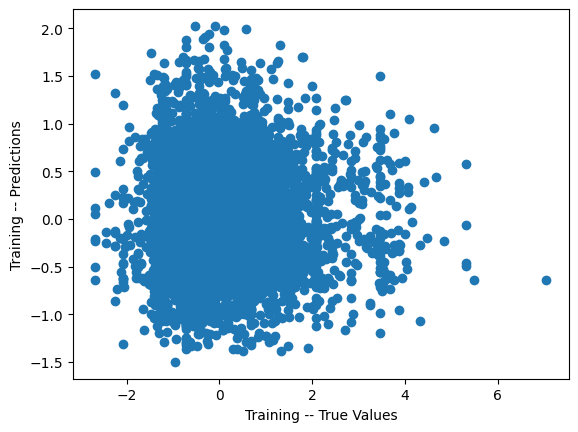

In [9]:
plt.scatter(train_vals, train_preds[:,0])
plt.xlabel('Training -- True Values')
plt.ylabel('Training -- Predictions')

In [11]:
from torchmetrics.regression import R2Score
import torch
r2score = R2Score()
print("Test R2 Score:")
print(r2score(torch.tensor(test_preds[:,0]), torch.tensor(test_vals)))
print("Train R2 Score:")
print(r2score(torch.tensor(train_preds[:,0]), torch.tensor(train_vals)))

Test R2 Score:
tensor(0.2123, dtype=torch.float64)
Train R2 Score:
tensor(-0.3056, dtype=torch.float64)


(array([6.323e+03, 7.630e+02, 2.540e+02, 8.600e+01, 4.100e+01, 1.600e+01,
        9.000e+00, 7.000e+00, 0.000e+00, 2.000e+00]),
 array([1.64419691e-06, 1.59733824e-03, 3.19303223e-03, 4.78872657e-03,
        6.38442067e-03, 7.98011478e-03, 9.57580842e-03, 1.11715030e-02,
        1.27671966e-02, 1.43628912e-02, 1.59585848e-02]),
 <BarContainer object of 10 artists>)

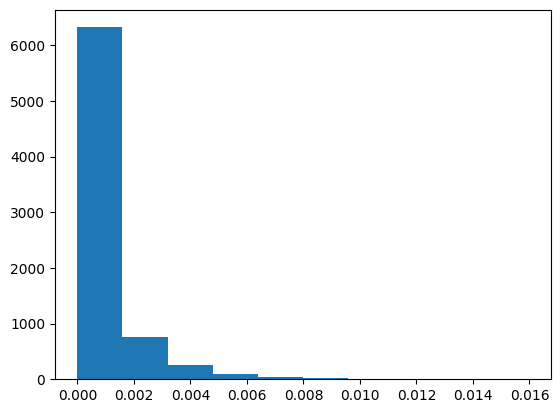

In [16]:
plt.hist(train_preds[:,3])

In [20]:
variance = train_preds[:,3]/(train_preds[:,1] * (train_preds[:,2]-1))    

(array([7.438e+03, 4.200e+01, 9.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([2.78901588e-02, 2.87873531e+05, 5.75747000e+05, 8.63620500e+05,
        1.15149400e+06, 1.43936750e+06, 1.72724100e+06, 2.01511450e+06,
        2.30298800e+06, 2.59086150e+06, 2.87873500e+06]),
 <BarContainer object of 10 artists>)

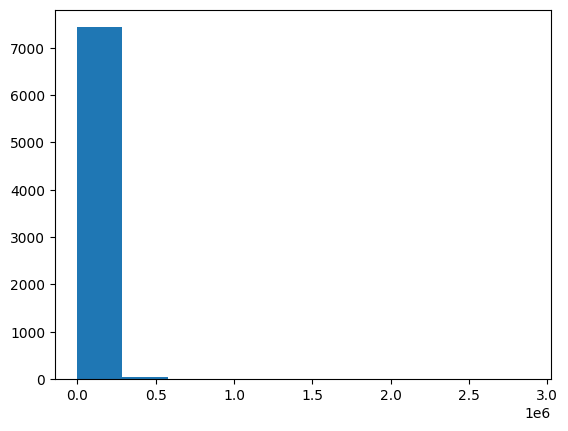

In [21]:
plt.hist(variance)

# Chemprop binary classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

/tmp/ipykernel_332716/288394649.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


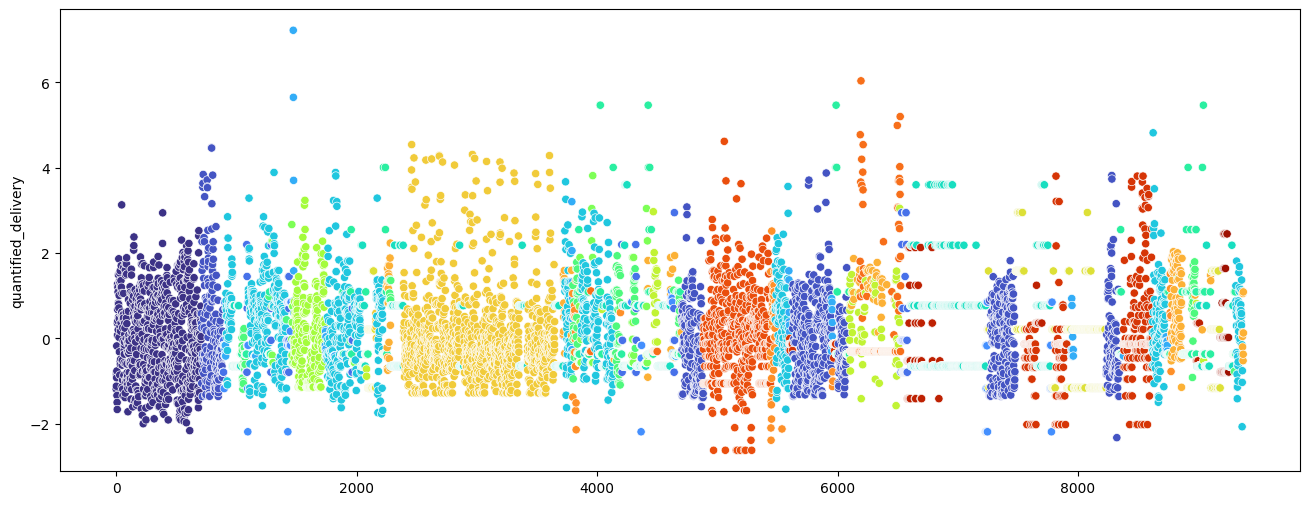

In [ ]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='turbo')
plt.legend([],[], frameon=False)

(array([8.100e+01, 1.507e+03, 4.639e+03, 2.165e+03, 6.970e+02, 1.480e+02,
        1.190e+02, 1.300e+01, 7.000e+00, 1.000e+00]),
 array([-2.62169095, -1.63712801, -0.65256508,  0.33199786,  1.3165608 ,
         2.30112374,  3.28568667,  4.27024961,  5.25481255,  6.23937549,
         7.22393842]),
 <BarContainer object of 10 artists>)

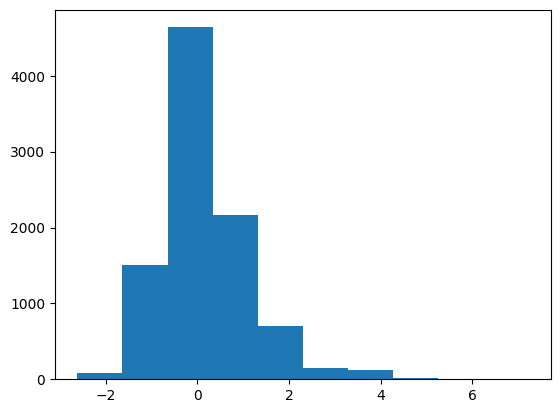

In [5]:
plt.hist(Ys)

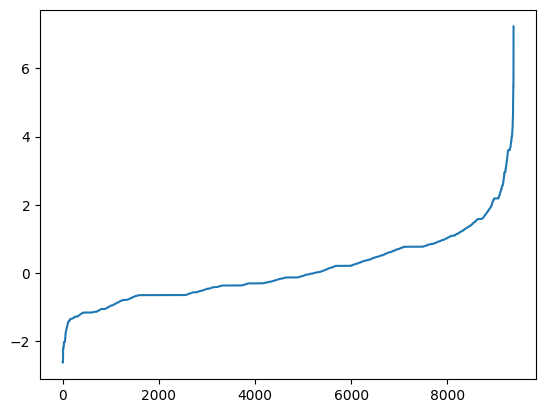

In [6]:
plt.plot(np.sort(Ys,axis=0))

In [7]:
Ys[Ys > 1.75] = 10
Ys[Ys <= 1.75] = 0
Ys[Ys > 1.75] = 1

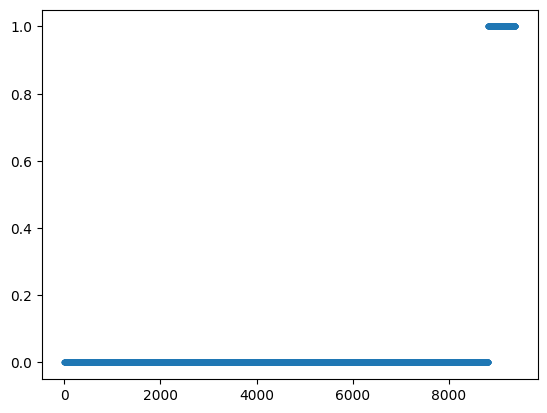

In [8]:
plt.plot(np.sort(Ys,axis=0), '.')

In [9]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [10]:
mp = nn.BondMessagePassing(depth=5, activation=nn.utils.Activation.RELU)
agg = nn.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.BinaryClassificationFFN(hidden_dim=1500, n_layers=3, dropout=0.1, activation='relu',output_transform=output_transform)

batch_norm = True
metric_list = None # AUCROC by default

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metric_list)

In [11]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=100,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 99: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s, train_loss_step=-3.89e+11, val_loss=-3.29e+11, train_loss_epoch=-4.04e+11]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s, train_loss_step=-3.89e+11, val_loss=-3.29e+11, train_loss_epoch=-4.04e+11]


In [12]:
results = trainer.test(mpnn, test_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.7376419305801392     │
└───────────────────────────┴───────────────────────────┘

In [13]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


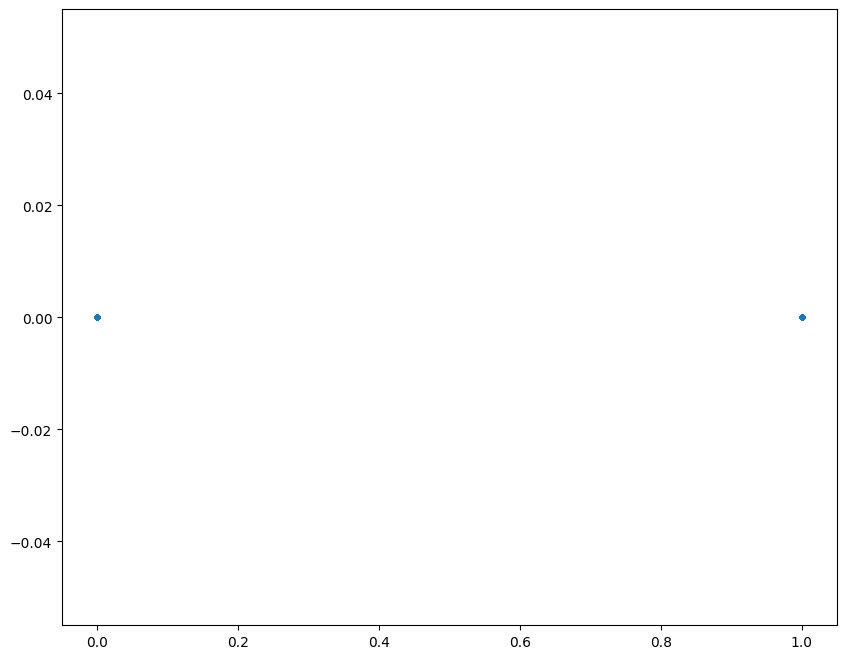

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(test_vals, test_preds, '.')

In [14]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

0.7376528488422514


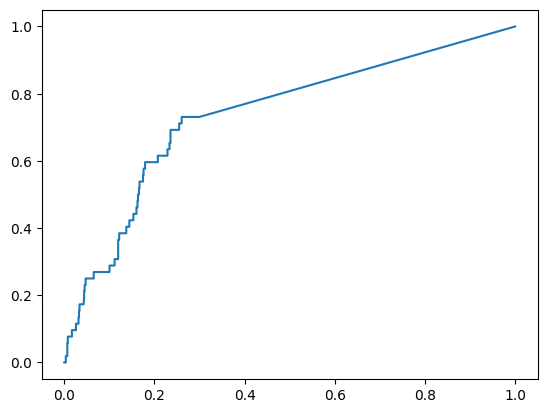

In [15]:
fpr, tpr, _ = roc_curve(test_vals, test_preds)
plt.plot(fpr, tpr)
print(auc(fpr, tpr))

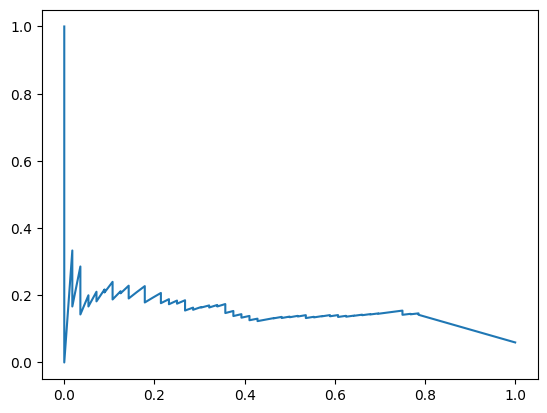

In [32]:
plt.plot(recall, precision, label='Test PR Curve')

# Chemeleon fine-tuning (without freezing) - Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

/tmp/ipykernel_333096/288394649.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


In [20]:
short_df = df[['smiles','quantified_delivery']].copy()
short_df = short_df.rename(columns={'smiles': 'SMILES'})
short_df = short_df.rename(columns={'quantified_delivery': 'ACTIVITY'})
short_df.to_csv('pulmonary/unique_data.csv',index=False)

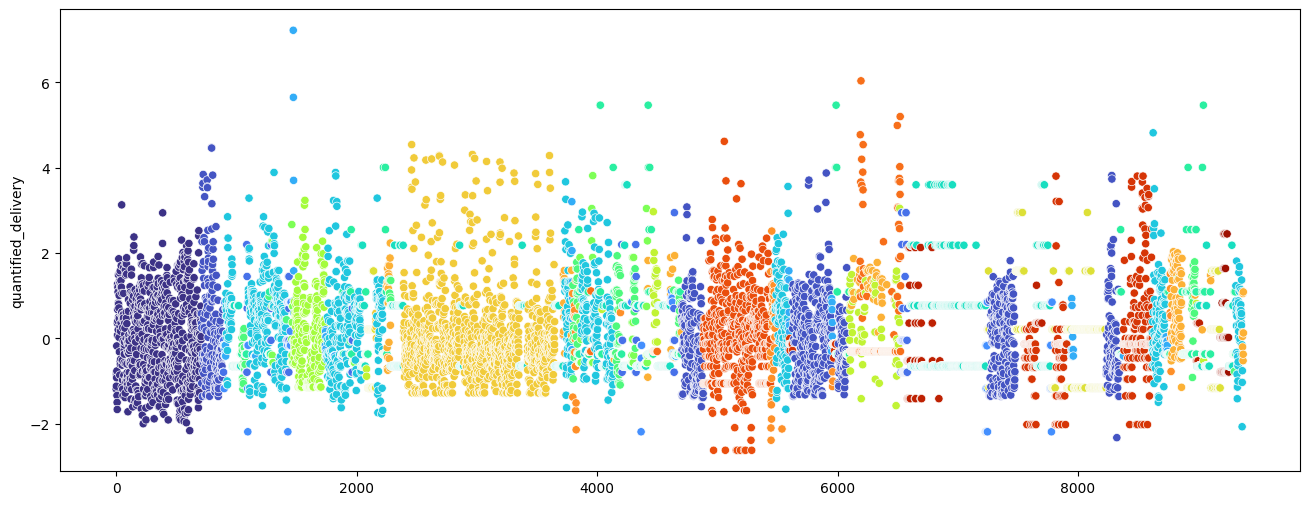

In [3]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='turbo')
plt.legend([],[], frameon=False)

(array([8.100e+01, 1.507e+03, 4.639e+03, 2.165e+03, 6.970e+02, 1.480e+02,
        1.190e+02, 1.300e+01, 7.000e+00, 1.000e+00]),
 array([-2.62169095, -1.63712801, -0.65256508,  0.33199786,  1.3165608 ,
         2.30112374,  3.28568667,  4.27024961,  5.25481255,  6.23937549,
         7.22393842]),
 <BarContainer object of 10 artists>)

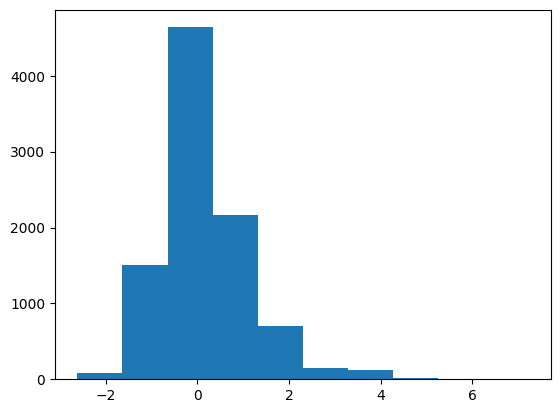

In [4]:
plt.hist(Ys)

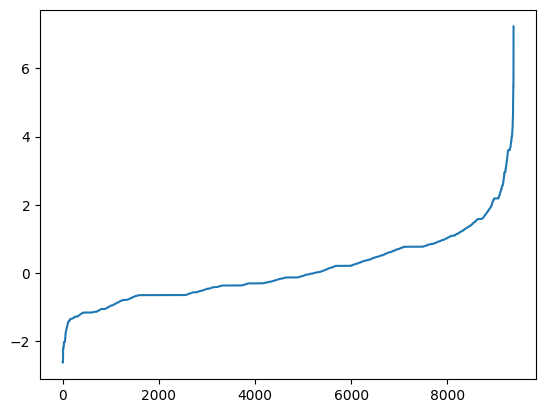

In [5]:
plt.plot(np.sort(Ys,axis=0))

In [6]:
Ys[Ys > 1.75] = 10
Ys[Ys <= 1.75] = 0
Ys[Ys > 1.75] = 1

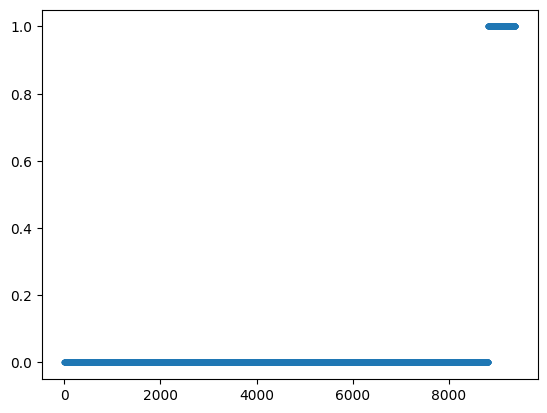

In [7]:
plt.plot(np.sort(Ys,axis=0), '.')

In [8]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [9]:
'''
from urllib.request import urlretrieve

urlretrieve(
    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
    "chemeleon_mp.pt",
)
'''

'\nfrom urllib.request import urlretrieve\n\nurlretrieve(\n    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",\n    "chemeleon_mp.pt",\n)\n'

In [10]:
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])
agg = nn.agg.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.BinaryClassificationFFN(input_dim=mp.output_dim, hidden_dim=1500, n_layers=3, dropout=0.1, activation='relu',output_transform=output_transform)
#predictor = nn.predictors.EvidentialFFN(hidden_dim=300, n_layers=1, dropout=0, activation='relu', output_transform=output_transform)

batch_norm = True
metric_list = None # AUCROC by default # [nn.metrics.BinaryAUCROC(), nn.metrics.BinaryAccuracy(), nn.metrics.BinaryF1Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metric_list)

In [11]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=[0],
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 15/15 [00:17<00:00,  0.85it/s, train_loss_step=-9.92e+8, val_loss=-8.32e+8, train_loss_epoch=-9.49e+8]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 15/15 [00:18<00:00,  0.80it/s, train_loss_step=-9.92e+8, val_loss=-8.32e+8, train_loss_epoch=-9.49e+8]


In [12]:
results = trainer.test(mpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.7260428071022034     │
└───────────────────────────┴───────────────────────────┘

In [13]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


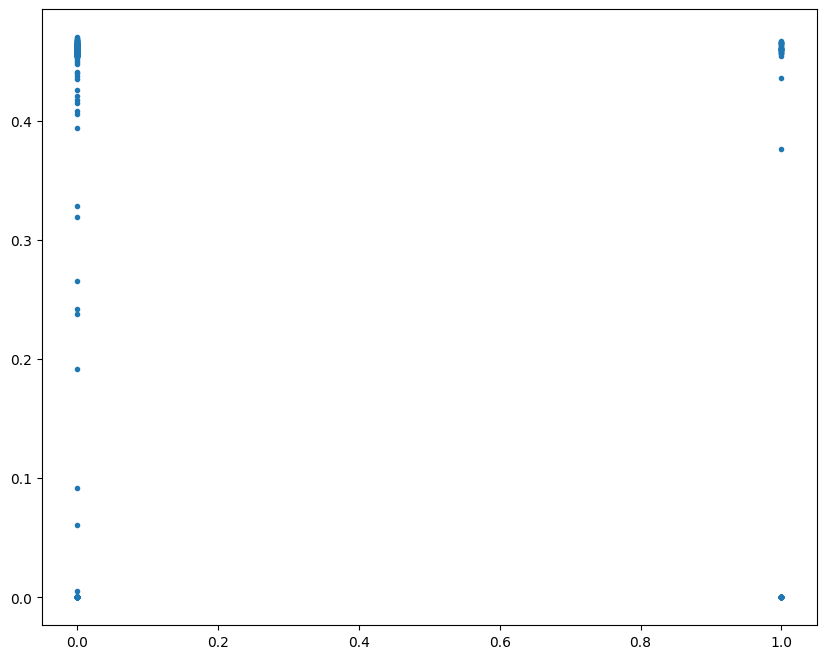

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(test_vals, test_preds, '.')

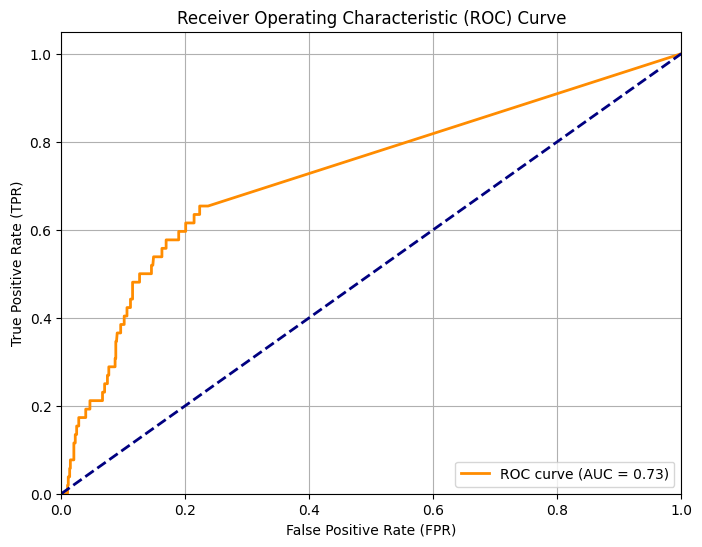

In [15]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

fpr, tpr, _ = roc_curve(test_vals, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Chemeleon fine-tuning with frozen weights

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

/tmp/ipykernel_332984/288394649.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


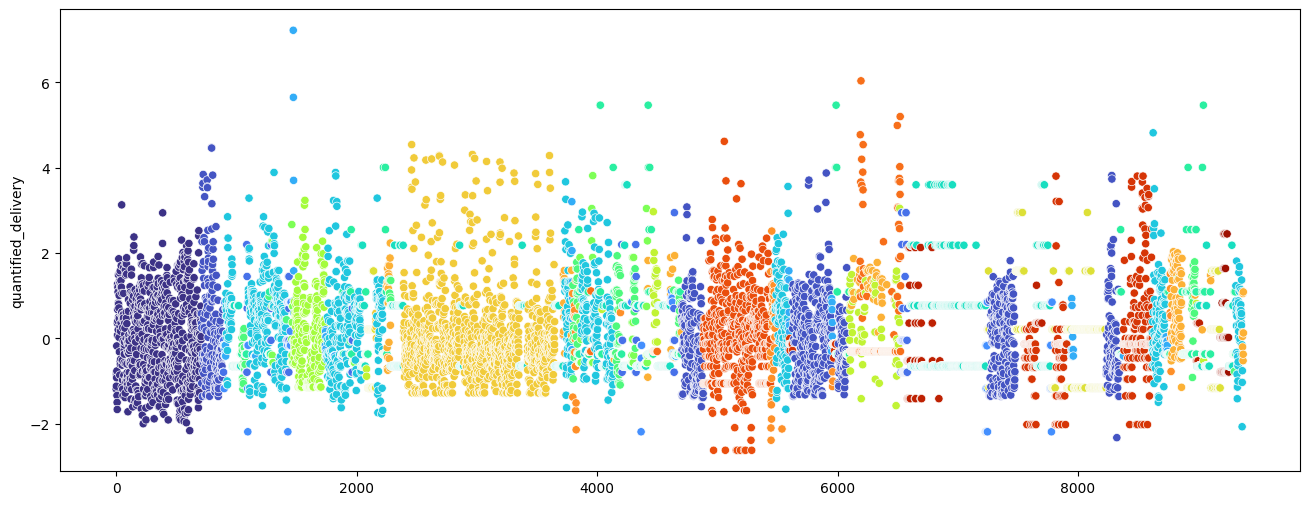

In [3]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='turbo')
plt.legend([],[], frameon=False)

(array([8.100e+01, 1.507e+03, 4.639e+03, 2.165e+03, 6.970e+02, 1.480e+02,
        1.190e+02, 1.300e+01, 7.000e+00, 1.000e+00]),
 array([-2.62169095, -1.63712801, -0.65256508,  0.33199786,  1.3165608 ,
         2.30112374,  3.28568667,  4.27024961,  5.25481255,  6.23937549,
         7.22393842]),
 <BarContainer object of 10 artists>)

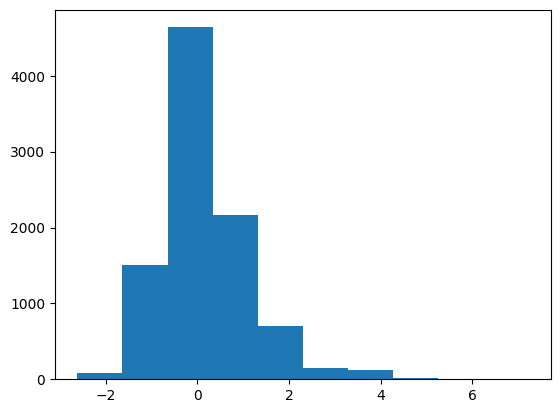

In [4]:
plt.hist(Ys)

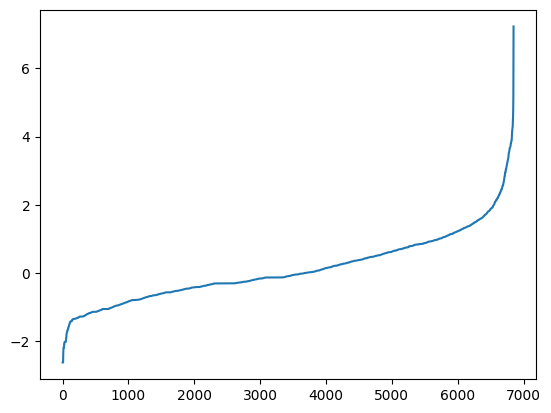

In [12]:
plt.plot(np.sort(Ys,axis=0))

In [6]:
Ys[Ys > 1.75] = 10
Ys[Ys <= 1.75] = 0
Ys[Ys > 1.75] = 1

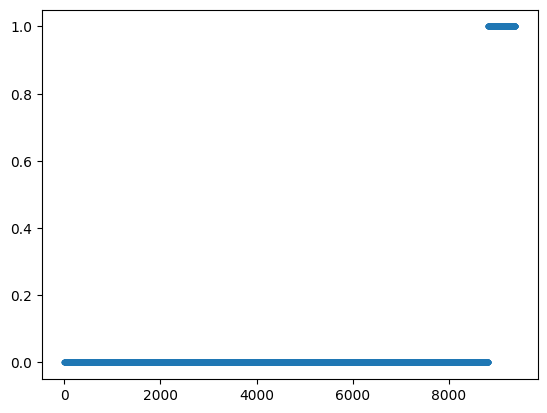

In [7]:
plt.plot(np.sort(Ys,axis=0), '.')

In [8]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [9]:
'''
from urllib.request import urlretrieve

urlretrieve(
    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",
    "chemeleon_mp.pt",
)
'''

'\nfrom urllib.request import urlretrieve\n\nurlretrieve(\n    r"https://zenodo.org/records/15460715/files/chemeleon_mp.pt",\n    "chemeleon_mp.pt",\n)\n'

In [10]:
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])
mp.eval()
mp.apply(lambda module: module.requires_grad_(False))

agg = nn.agg.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.BinaryClassificationFFN(input_dim=mp.output_dim, hidden_dim=1500, n_layers=3, dropout=0.1, activation='relu',output_transform=output_transform)

batch_norm = True
metric_list = None # AUCROC by default # [nn.metrics.BinaryAUCROC(), nn.metrics.BinaryAccuracy(), nn.metrics.BinaryF1Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metric_list)

In [11]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=[0],
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s, train_loss_step=-1.18e+8, val_loss=-1.43e+8, train_loss_epoch=-1.27e+8]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 15/15 [00:13<00:00,  1.11it/s, train_loss_step=-1.18e+8, val_loss=-1.43e+8, train_loss_epoch=-1.27e+8]


In [12]:
results = trainer.test(mpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.5598494410514832     │
└───────────────────────────┴───────────────────────────┘

In [13]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


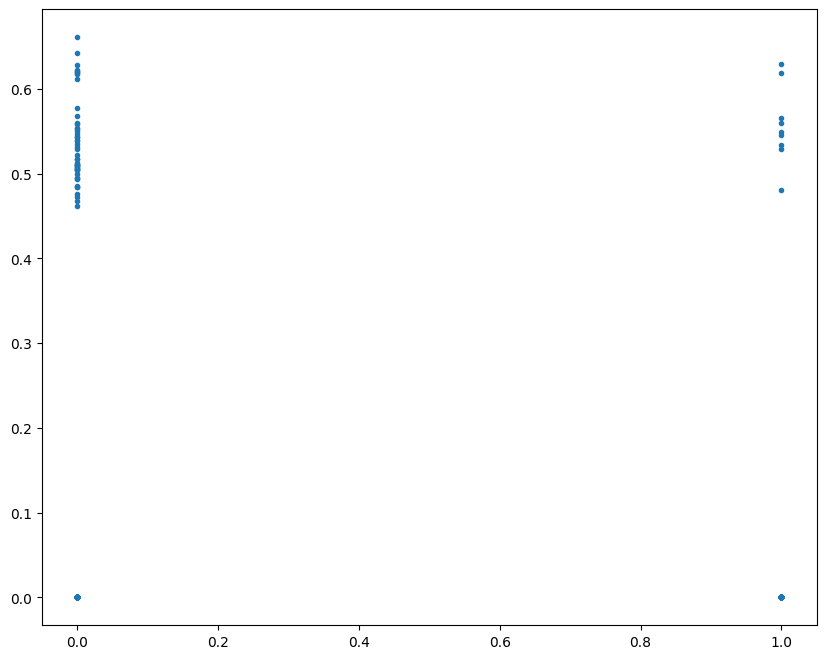

In [14]:
plt.figure(figsize=(10, 8))
plt.plot(test_vals, test_preds, '.')

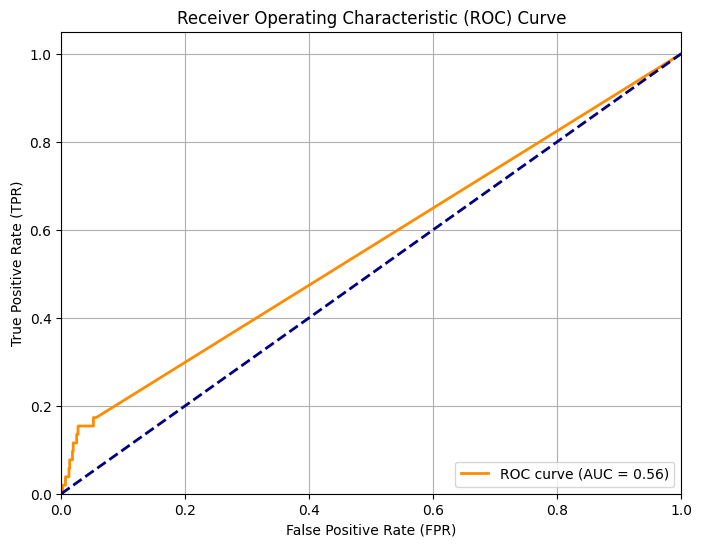

In [15]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

fpr, tpr, _ = roc_curve(test_vals, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Cut short data -- regression with foundation model

Remove categorial points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

/tmp/ipykernel_358758/1784833884.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


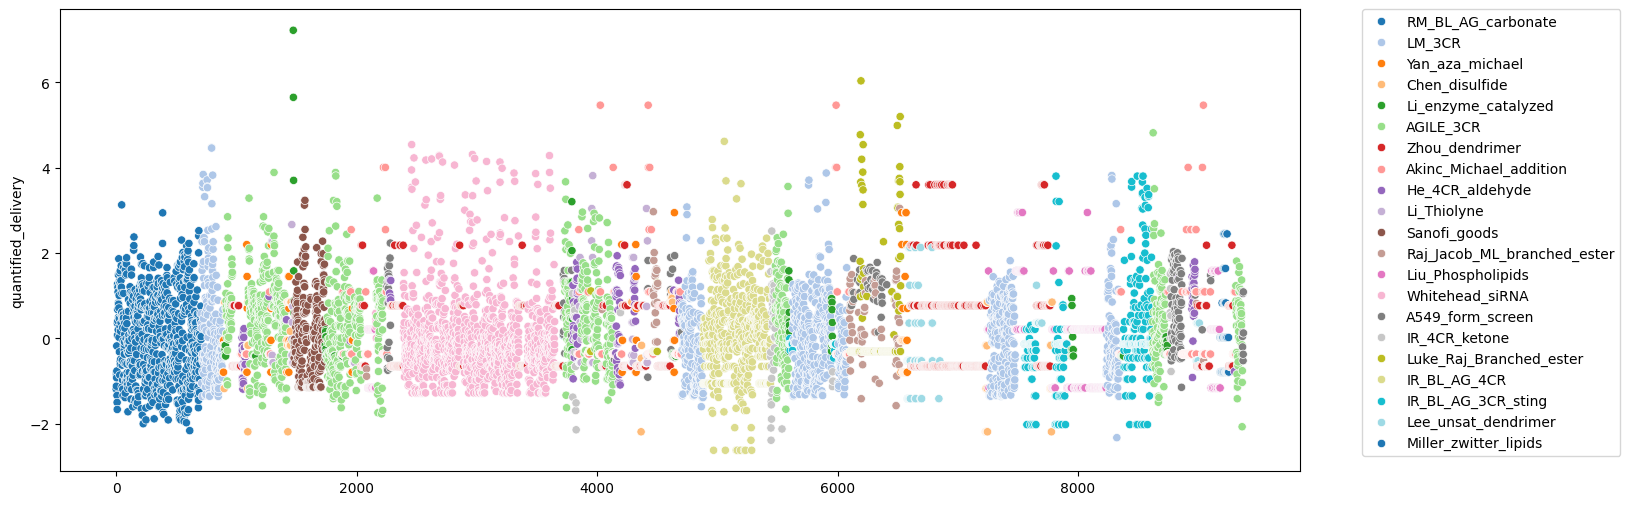

In [3]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

(array([190.,   0.,   0., 293.,   0.,   0.,  76.,   0.,   0.,  13.]),
 array([-1.15979472, -0.74859478, -0.33739483,  0.07380512,  0.48500507,
         0.89620501,  1.30740496,  1.71860491,  2.12980486,  2.5410048 ,
         2.95220475]),
 <BarContainer object of 10 artists>)

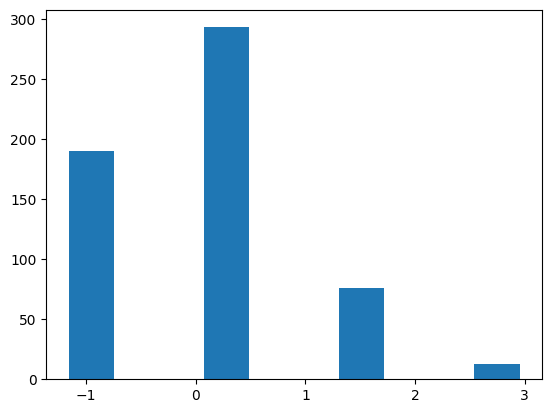

In [4]:
#Akinc_Michael_addition, Zhou_dendrimer, Liu_Phospholipids
plt.hist(df[df['Experiment_ID'] == 'Liu_Phospholipids']['quantified_delivery'])

In [5]:
df = df[~df['Experiment_ID'].isin(['Liu_Phospholipids', 'Zhou_dendrimer', 'Akinc_Michael_addition'])].reset_index(drop=True)
smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

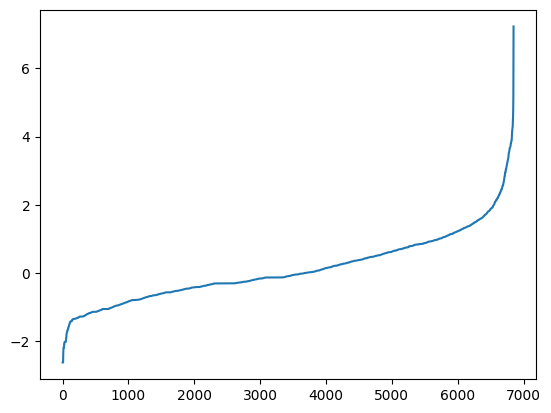

In [6]:
plt.plot(np.sort(Ys,axis=0))

In [7]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=128, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=128, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=128, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [8]:
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])

agg = nn.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.RegressionFFN(input_dim=mp.output_dim, hidden_dim=300, n_layers=3, dropout=0.1, activation='relu',output_transform=output_transform)

batch_norm = True
metrics = [nn.MSE(), nn.MAE(), nn.RMSE(), nn.R2Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metrics)

In [9]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 43/43 [00:12<00:00,  3.31it/s, train_loss_step=0.218, val_loss=0.479, train_loss_epoch=0.229]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 43/43 [00:13<00:00,  3.24it/s, train_loss_step=0.218, val_loss=0.479, train_loss_epoch=0.229]


In [10]:
results = trainer.test(dataloaders=test_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=17-val_loss=0.48.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=17-val_loss=0.48.ckpt
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.49563807249069214    │
│         test/mse          │    0.5365877747535706     │
│          test/r2          │    0.4973398447036743     │
│         test/rmse         │    0.7325215339660645     │
└───────────────────────────┴───────────────────────────┘

In [11]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]


In [12]:
from torchmetrics.regression import R2Score
import torch
r2score = R2Score()
print("Test R2 Score:")
print(r2score(torch.tensor(test_preds), torch.tensor(test_vals)))

Test R2 Score:
tensor(0.4973, dtype=torch.float64)


In [13]:
from scipy.stats import pearsonr, spearmanr
pearson_corr, _ = pearsonr(test_vals, test_preds)
spearman_corr, _ = spearmanr(test_vals, test_preds)
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation: 0.7181
Spearman Correlation: 0.7273


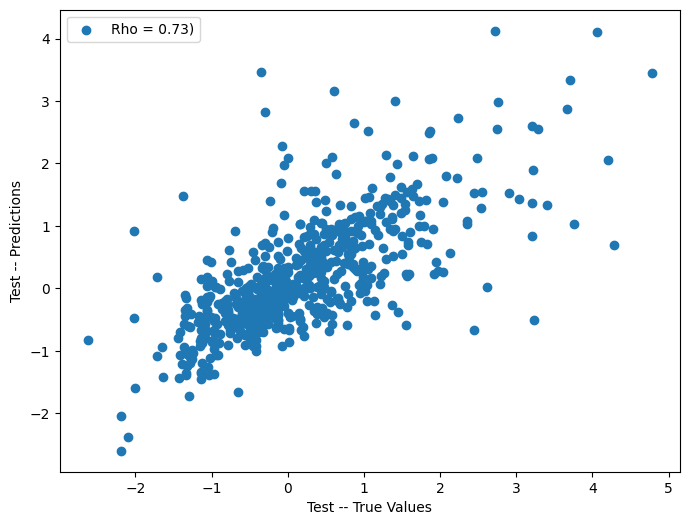

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(test_vals, test_preds, label=f'Rho = {spearman_corr:.2f})')
plt.xlabel('Test -- True Values')
plt.ylabel('Test -- Predictions')
plt.legend(loc="upper left")

# Cut short data -- regression

Remove categorial points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

/tmp/ipykernel_342596/1784833884.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


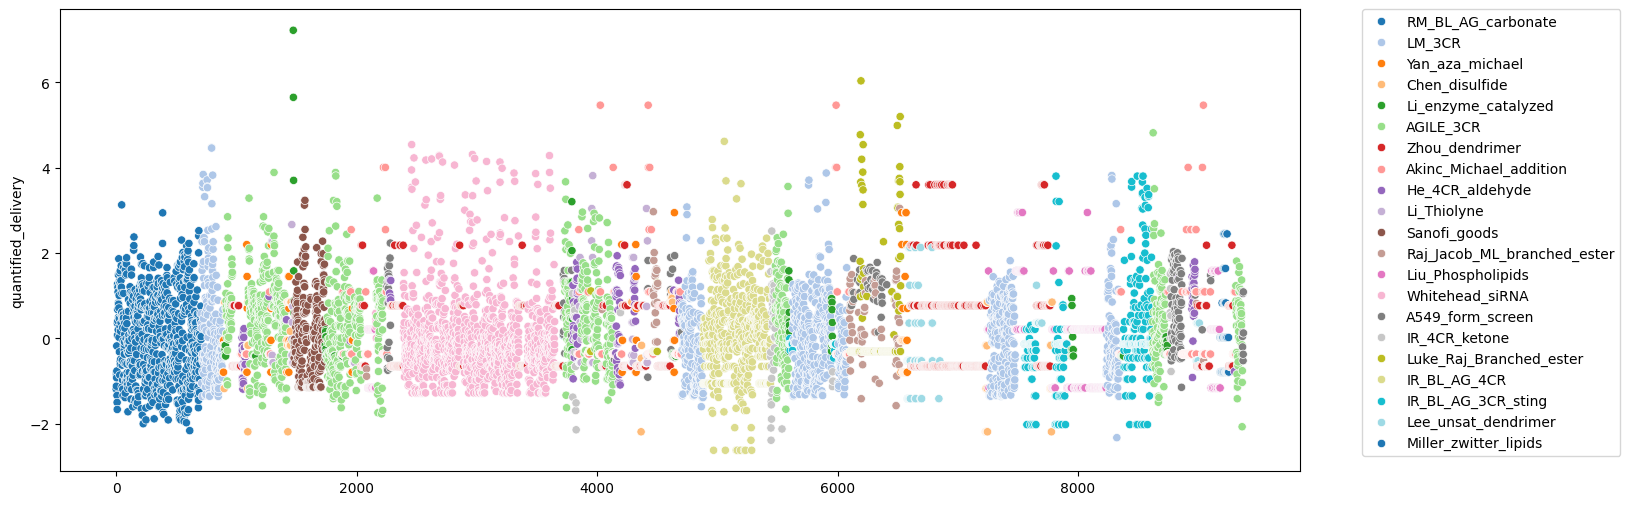

In [3]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

(array([190.,   0.,   0., 293.,   0.,   0.,  76.,   0.,   0.,  13.]),
 array([-1.15979472, -0.74859478, -0.33739483,  0.07380512,  0.48500507,
         0.89620501,  1.30740496,  1.71860491,  2.12980486,  2.5410048 ,
         2.95220475]),
 <BarContainer object of 10 artists>)

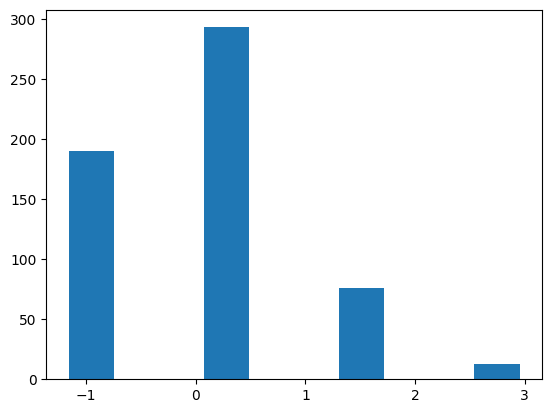

In [4]:
#Akinc_Michael_addition, Zhou_dendrimer, Liu_Phospholipids
plt.hist(df[df['Experiment_ID'] == 'Liu_Phospholipids']['quantified_delivery'])

In [5]:
df = df[~df['Experiment_ID'].isin(['Liu_Phospholipids', 'Zhou_dendrimer', 'Akinc_Michael_addition'])].reset_index(drop=True)
smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

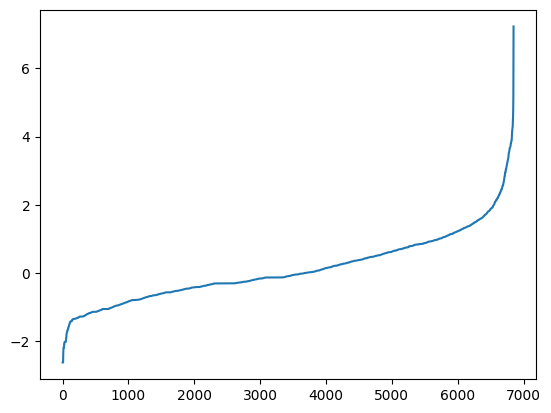

In [6]:
plt.plot(np.sort(Ys,axis=0))

In [7]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [11]:
mp = nn.BondMessagePassing(depth=3, activation=nn.utils.Activation.RELU)

agg = nn.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.RegressionFFN(input_dim=mp.output_dim, hidden_dim=300, n_layers=1, dropout=0.1, activation='relu',output_transform=output_transform)

batch_norm = True
metrics = [nn.MSE(), nn.MAE(), nn.RMSE(), nn.R2Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metrics)

In [12]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/LNP/ml/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s, train_loss_step=0.646, val_loss=0.762, train_loss_epoch=0.695]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11/11 [00:06<00:00,  1.71it/s, train_loss_step=0.646, val_loss=0.762, train_loss_epoch=0.695]


In [13]:
results = trainer.test(dataloaders=test_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=18-val_loss=0.76.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/akshay/Desktop/LNP/ml/checkpoints/best-epoch=18-val_loss=0.76.ckpt
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │    0.6701107621192932     │
│         test/mse          │    0.8128517866134644     │
│          test/r2          │    0.23854351043701172    │
│         test/rmse         │    0.9015829563140869     │
└───────────────────────────┴───────────────────────────┘

In [14]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


Text(0, 0.5, 'Test -- Predictions')

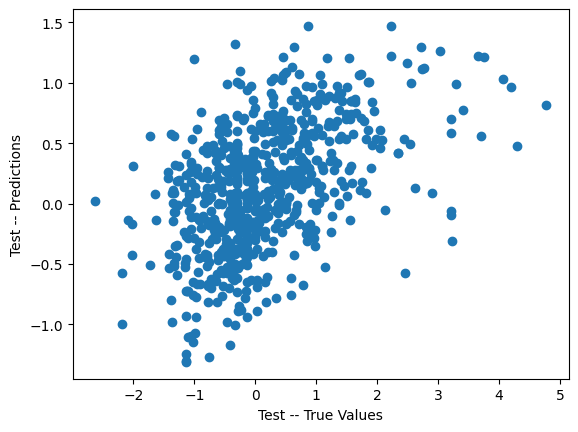

In [15]:
plt.scatter(test_vals, test_preds)
plt.xlabel('Test -- True Values')
plt.ylabel('Test -- Predictions')

'\nfrom torchmetrics.regression import R2Score\nimport torch\nr2score = R2Score()\nprint("Test R2 Score:")\nprint(r2score(torch.tensor(test_preds), torch.tensor(test_vals)))\nprint("Train R2 Score:")\nprint(r2score(torch.tensor(train_preds), torch.tensor(train_vals)))\n'

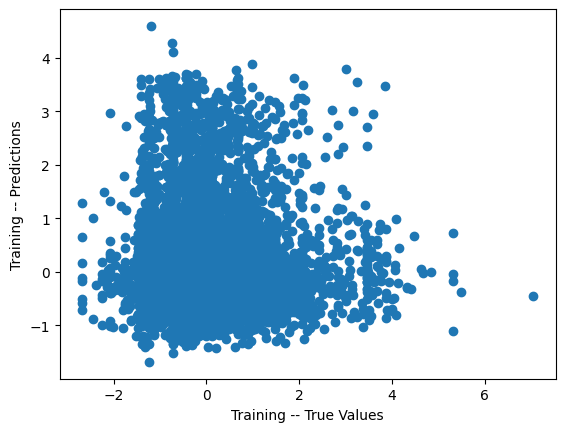

In [ ]:
plt.scatter(train_vals, train_preds)
plt.xlabel('Training -- True Values')
plt.ylabel('Training -- Predictions')

In [ ]:
from torchmetrics.regression import R2Score
import torch
r2score = R2Score()
print("Test R2 Score:")
print(r2score(torch.tensor(test_preds), torch.tensor(test_vals)))
print("Train R2 Score:")
print(r2score(torch.tensor(train_preds), torch.tensor(train_vals)))

# Cut short data -- classification with foundational model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [2]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

/tmp/ipykernel_342389/1784833884.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


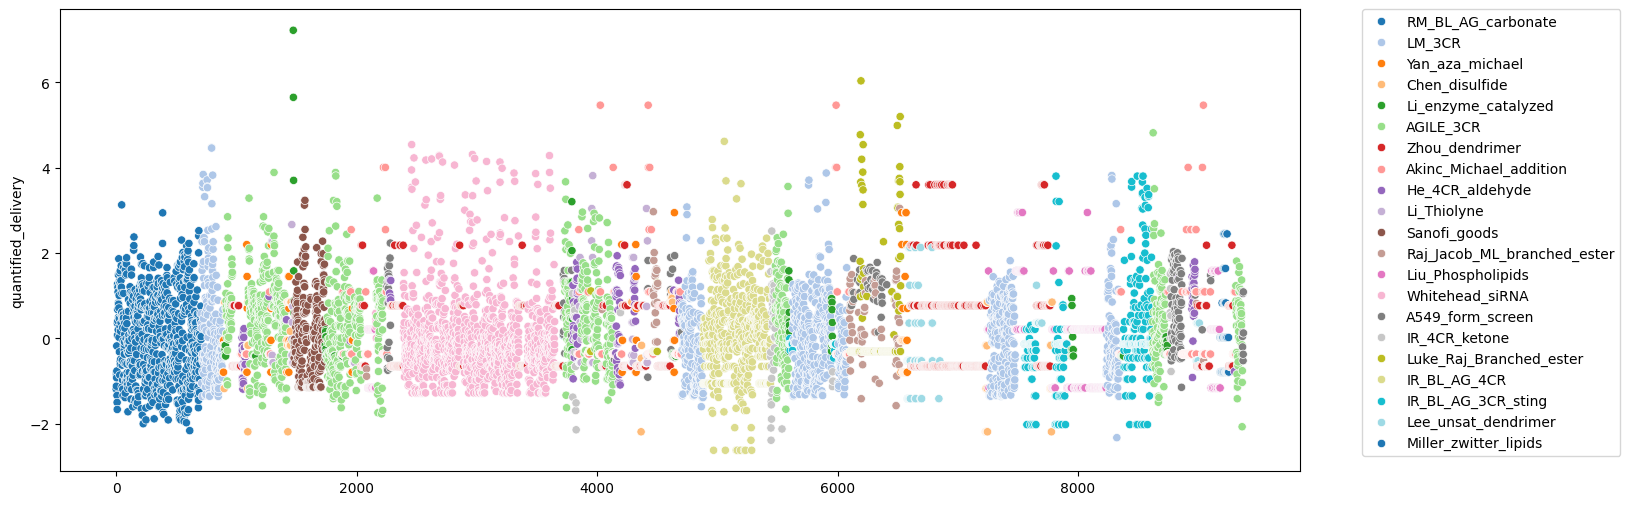

In [3]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

(array([190.,   0.,   0., 293.,   0.,   0.,  76.,   0.,   0.,  13.]),
 array([-1.15979472, -0.74859478, -0.33739483,  0.07380512,  0.48500507,
         0.89620501,  1.30740496,  1.71860491,  2.12980486,  2.5410048 ,
         2.95220475]),
 <BarContainer object of 10 artists>)

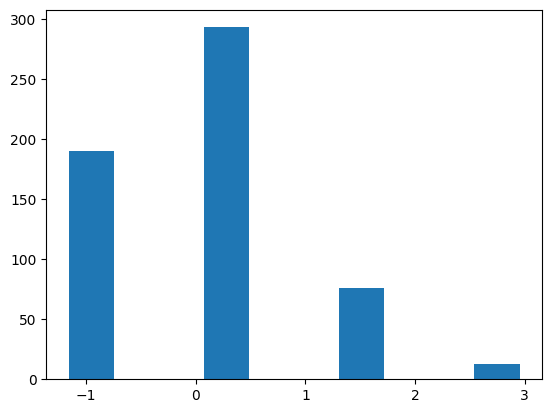

In [4]:
#Akinc_Michael_addition, Zhou_dendrimer, Liu_Phospholipids
plt.hist(df[df['Experiment_ID'] == 'Liu_Phospholipids']['quantified_delivery'])

In [5]:
df = df[~df['Experiment_ID'].isin(['Liu_Phospholipids', 'Zhou_dendrimer', 'Akinc_Michael_addition'])].reset_index(drop=True)
smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

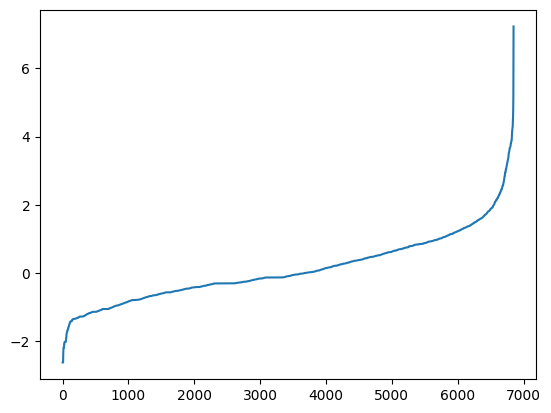

In [6]:
plt.plot(np.sort(Ys,axis=0))

In [7]:
Ys[Ys > 1.75] = 10
Ys[Ys <= 1.75] = 0
Ys[Ys > 1.75] = 1

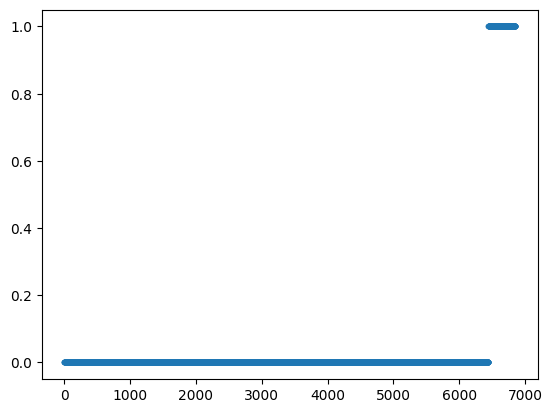

In [8]:
plt.plot(np.sort(Ys,axis=0), '.')

In [9]:
datapoints = [data.MoleculeDatapoint.from_smi(smi,y) for smi,y in zip(smis, Ys)]

mols = [d.mol for d in datapoints]

train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1), seed=42)
train_data, val_data, test_data = data.split_data_by_indices(datapoints, train_indices, val_indices, test_indices)

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer=featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer=featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer=featurizer)

train_loader = data.build_dataloader(train_dset, batch_size=512, num_workers=0, shuffle=True)
val_loader = data.build_dataloader(val_dset, batch_size=512, num_workers=0, shuffle=False)
test_loader = data.build_dataloader(test_dset, batch_size=512, num_workers=0, shuffle=False)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [10]:
chemeleon_mp = torch.load("chemeleon_mp.pt", weights_only=True)
mp = nn.BondMessagePassing(**chemeleon_mp['hyper_parameters'])
mp.load_state_dict(chemeleon_mp['state_dict'])
agg = nn.agg.MeanAggregation()

output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
predictor = nn.predictors.BinaryClassificationFFN(input_dim=mp.output_dim, hidden_dim=1500, n_layers=3, dropout=0.1, activation='relu',output_transform=output_transform)
#predictor = nn.predictors.EvidentialFFN(hidden_dim=300, n_layers=1, dropout=0, activation='relu', output_transform=output_transform)

batch_norm = True
metric_list = None # AUCROC by default # [nn.metrics.BinaryAUCROC(), nn.metrics.BinaryAccuracy(), nn.metrics.BinaryF1Score()]

mpnn = models.MPNN(mp, agg, predictor, batch_norm, metric_list)

In [11]:
checkpointing = ModelCheckpoint("checkpoints", "best-{epoch}-{val_loss:.2f}", "val_loss", mode="min", save_last=True)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=[0],
    max_epochs=20,
    callbacks=[checkpointing]
)

trainer.fit(mpnn, train_loader, val_loader)

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/akshay/apps/miniconda3/envs/chemprop/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/akshay/Desktop/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Epoch 19: 100%|██████████| 11/11 [00:12<00:00,  0.86it/s, train_loss_step=-1.68e+8, val_loss=-1.37e+8, train_loss_epoch=-1.64e+8]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 11/11 [00:13<00:00,  0.80it/s, train_loss_step=-1.68e+8, val_loss=-1.37e+8, train_loss_epoch=-1.64e+8]


In [12]:
results = trainer.test(mpnn, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/roc          │    0.6344426870346069     │
└───────────────────────────┴───────────────────────────┘

In [15]:
test_preds = np.concatenate(trainer.predict(mpnn,test_loader),axis=0).flatten()
test_vals = np.concatenate(test_loader.dataset.Y,axis=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/akshay/apps/miniconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


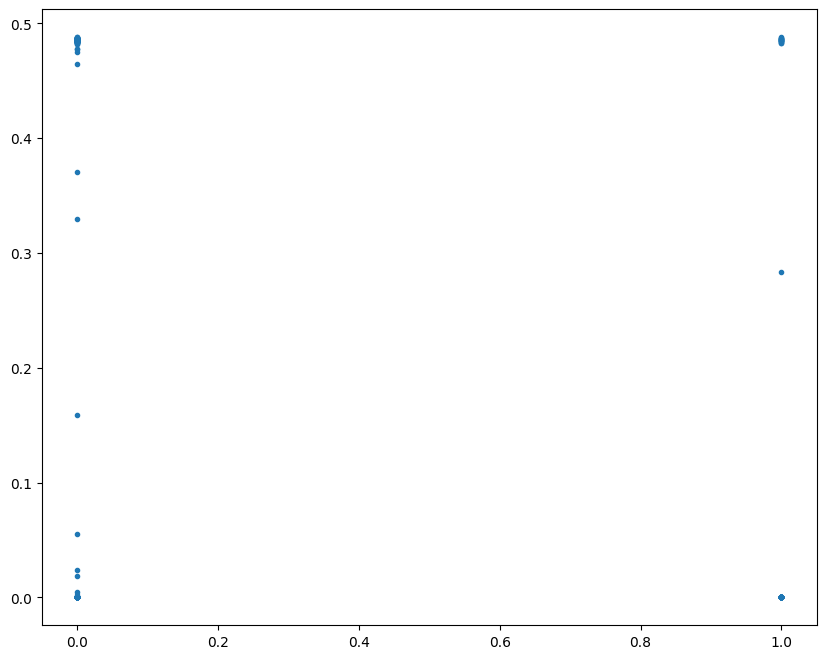

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(test_vals, test_preds, '.')

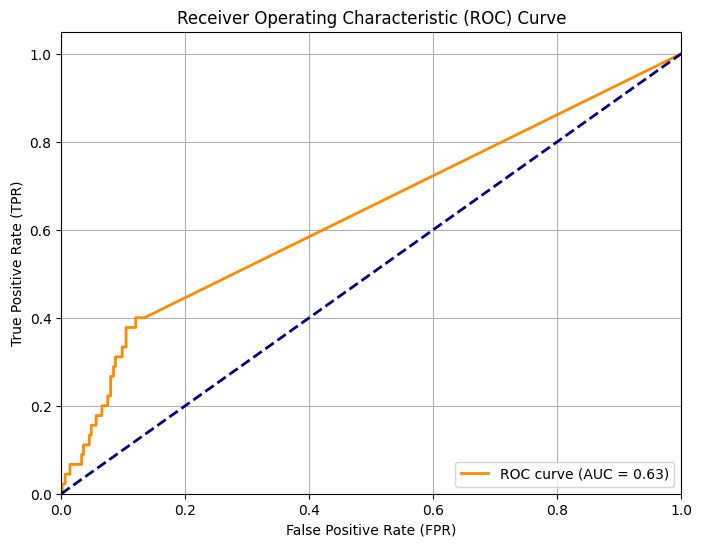

In [17]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

fpr, tpr, _ = roc_curve(test_vals, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pathlib import Path
from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from chemprop import data, featurizers, models, nn

In [22]:
input_path = Path.cwd() / 'pulmonary' / 'data' / 'all_data.csv'
df = pd.read_csv(input_path)

smiles_col = 'smiles'
target_col = ['quantified_delivery']

df = df.loc[df.groupby(smiles_col)['quantified_delivery'].idxmax()].reset_index(drop=True)

/tmp/ipykernel_415527/1784833884.py:2: DtypeWarning: Columns (34,35,40,42,44,47,48,49,53,54,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path)


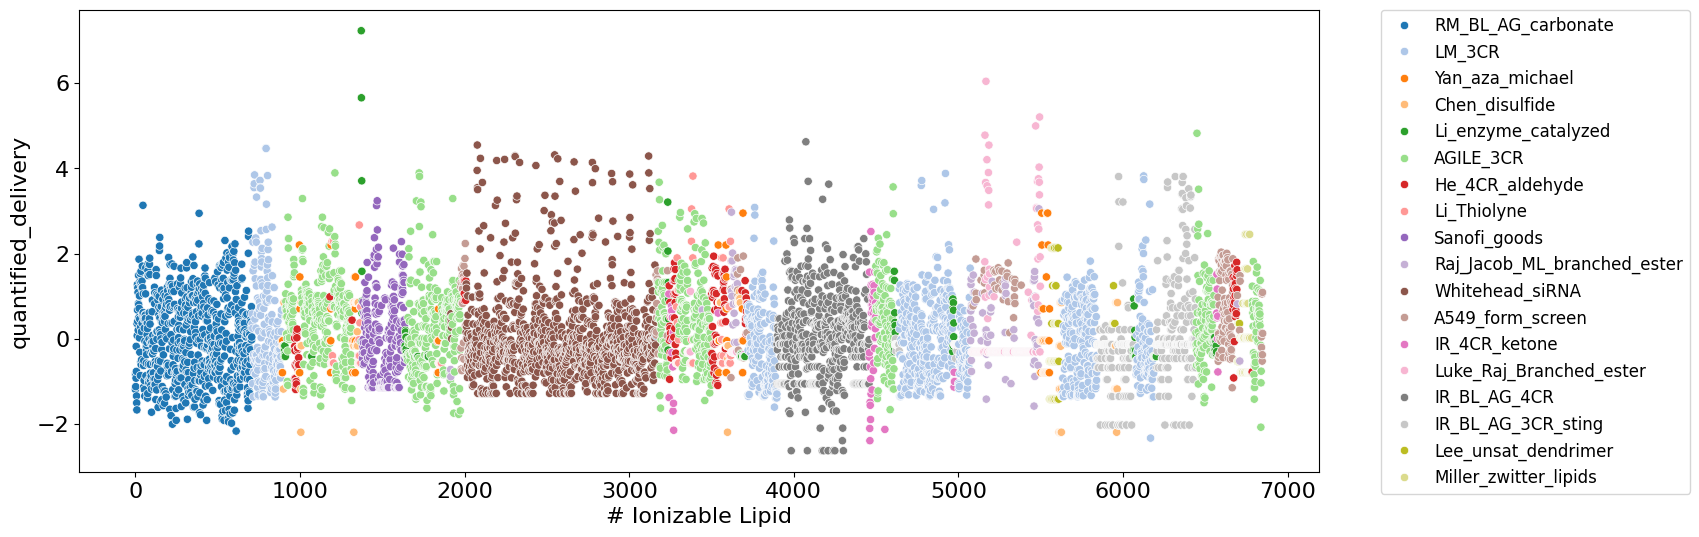

In [20]:
plt.figure(figsize=(16, 6))
plt.rcParams['font.size'] = 16
sns.scatterplot(data=df, x=np.arange(len(df)), y='quantified_delivery', hue='Experiment_ID', palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='12')
plt.xlabel('# Ionizable Lipid')
plt.savefig('pulmonary_data_distribution.png', bbox_inches='tight',dpi=300)

(array([190.,   0.,   0., 293.,   0.,   0.,  76.,   0.,   0.,  13.]),
 array([-1.15979472, -0.74859478, -0.33739483,  0.07380512,  0.48500507,
         0.89620501,  1.30740496,  1.71860491,  2.12980486,  2.5410048 ,
         2.95220475]),
 <BarContainer object of 10 artists>)

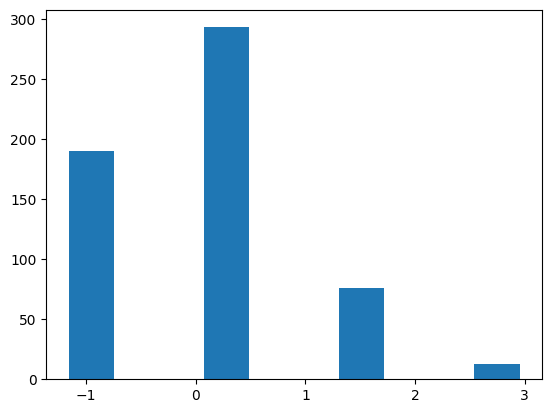

In [ ]:
#Akinc_Michael_addition, Zhou_dendrimer, Liu_Phospholipids
plt.hist(df[df['Experiment_ID'] == 'Liu_Phospholipids']['quantified_delivery'])

In [9]:
df = df[~df['Experiment_ID'].isin(['Liu_Phospholipids', 'Zhou_dendrimer', 'Akinc_Michael_addition'])].reset_index(drop=True)
smis = df.loc[:,smiles_col].values
Ys = df.loc[:, target_col].values

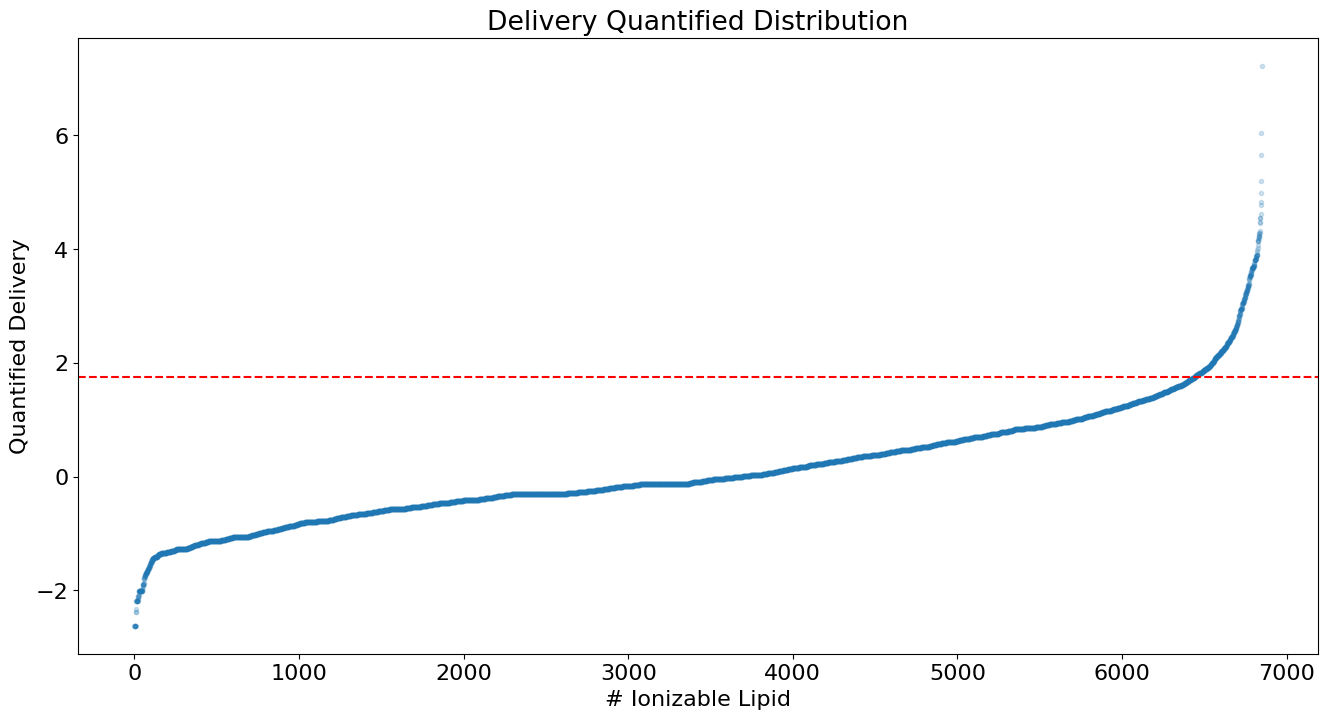

In [18]:
plt.figure(figsize=(16, 8))
plt.rcParams['font.size'] = 16
plt.plot(np.sort(Ys,axis=0),'.',alpha=0.2)
plt.axhline(y=1.75, color='r', linestyle='--', label='Threshold')
plt.title('Delivery Quantified Distribution')
plt.ylabel('Quantified Delivery')
plt.xlabel('# Ionizable Lipid')
plt.savefig('pulmonary_delivery_distribution_2.png', bbox_inches='tight',dpi=300)